# Homework 5-1: Obtaining K values
## Abby Baskind
## 3 October 2023

In [1]:
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import xarray as xr
import pandas as pd
import scipy
from datetime import datetime, timedelta
import time
import seaborn
import matplotlib.dates as mdates
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
import math
import netCDF4 as nc
import requests

# Import K's code for calculating the coefficients of the carb system
import calc_coeffs as co2
from importlib import reload
import warnings
warnings.filterwarnings('ignore')
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker

# 1. Check that your results are accurate:
At T = 20 (°C), S = 34.5 (‰)
results are:
* K$_0$ = 0.0325 (mol kg-1 atm-1)
* K$_1$ = 1.3079 × 10-6 (mol kg-1)
* K$_2$ = 9.1142 × 10-10 (mol kg-1)


In [3]:
T = 20
S = 34.5
coeffs = co2.calc_coeffs(T,S)
print('K0 = ' + str(coeffs['k0']))
print('K1 = ' + str(coeffs['k1']))
print('K2 = ' + str(coeffs['k2']))

K0 = 0.03249521338283152
K1 = 1.3078547027904889e-06
K2 = 9.114186029384211e-10


# 2. Make plots showing how these values change with T and S ranging (T = 0-35 (°C) and S = 30-40 (‰))

To make K's function work with arrays of temperature and salinity, I added this line to the code:
```python
[T,S] = np.meshgrid(T,S)
```

Now, the outputs of `calc_coeffs()` should by numpy arrays with the same dimensions as TxS.

In [2]:
T = np.arange(0,35.1,0.1)
S = np.arange(20,40.1,0.1)
[t,s] = np.meshgrid(T, S)
coeffs = co2.calc_coeffs(t,s)

Text(0, 0.5, 'Salinity [PSU]')

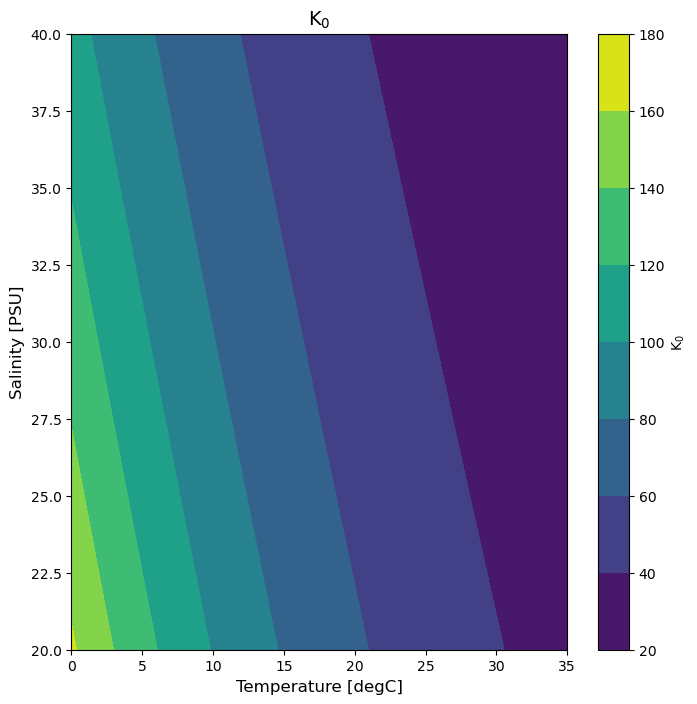

In [5]:
fig, ax = plt.subplots(figsize = [8,8])

im = ax.contourf(t,s,coeffs['k0']*coeffs['k1']/coeffs['k2'])
cbar = plt.colorbar(im, ax = ax)
cbar.set_label('K$_0$')
# ax.contour(t,s,coeffs['k0'], cmap = 'Greys_r')
ax.set_title('K$_0$', fontsize = 14)
ax.set_xlabel('Temperature [degC]', fontsize = 12)
ax.set_ylabel('Salinity [PSU]', fontsize = 12)

Text(0, 0.5, 'Salinity [PSU]')

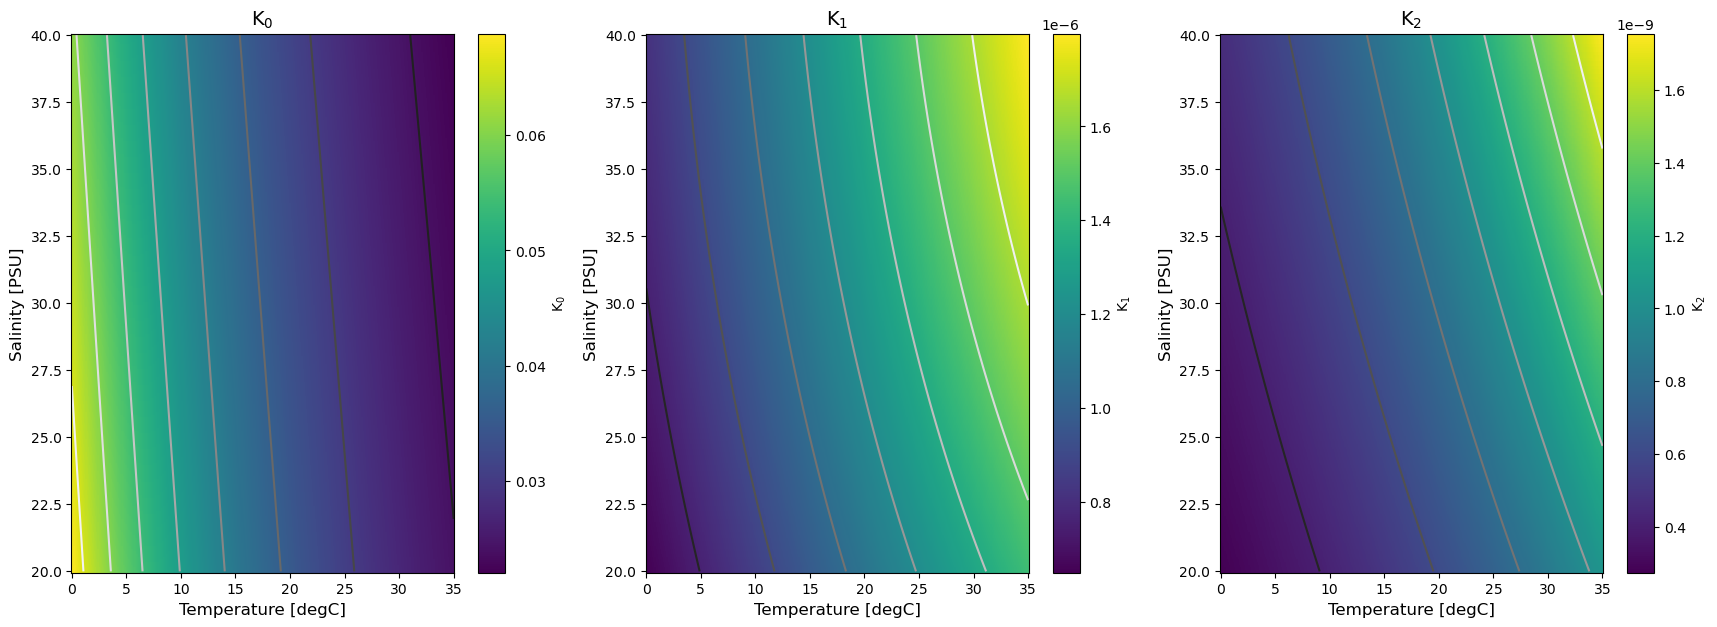

In [3]:
fig, axarr = plt.subplots(ncols = 3, figsize = [21,7])
axarr = axarr.flatten()

# K0
ax = axarr[0]
im = ax.pcolormesh(t,s,coeffs['k0'])
cbar = plt.colorbar(im, ax = ax)
cbar.set_label('K$_0$')
ax.contour(t,s,coeffs['k0'], cmap = 'Greys_r')
ax.set_title('K$_0$', fontsize = 14)
ax.set_xlabel('Temperature [degC]', fontsize = 12)
ax.set_ylabel('Salinity [PSU]', fontsize = 12)

# K1
ax = axarr[1]
im = ax.pcolormesh(t,s,coeffs['k1'])
cbar = plt.colorbar(im, ax = ax)
cbar.set_label('K$_1$')
ax.contour(t,s,coeffs['k1'], cmap = 'Greys_r')
ax.set_title('K$_1$', fontsize = 14)
ax.set_xlabel('Temperature [degC]', fontsize = 12)
ax.set_ylabel('Salinity [PSU]', fontsize = 12)

# K2
ax = axarr[2]
im = ax.pcolormesh(t,s,coeffs['k2'])
cbar = plt.colorbar(im, ax = ax)
cbar.set_label('K$_2$')
ax.contour(t,s,coeffs['k2'], cmap = 'Greys_r')
ax.set_title('K$_2$', fontsize = 14)
ax.set_xlabel('Temperature [degC]', fontsize = 12)
ax.set_ylabel('Salinity [PSU]', fontsize = 12)

- K$_0$
   - K$_0$ is solubility of CO2 in seawater (Weiss 1974)
       - CO2 is more soluble in colder, fresher water, though the effect of salinity is small
   - decreases *slightly* (i.e. barely at all) with increasing salinity
   - temperature has a larger effect on K$_0$ than salinity
       - K$_0$ increases with decreasing temperature
       - the change in K$_0$ with decreasing temperature increases at lower temperatures
- K$_1$
   - $K_1 = \frac{[H^+][HCO_2^-]}{[CO_2]}$ (Millero 1995)
       - as K$_1$ increases, $[HCO_2^-]$ increases relative to $[CO_2]$
       - at higher temperatures and lower salinities, $[HCO_2^-]$ increases relative to $pCO_2$
   - decreases *slightly* (i.e. slightly more than with K$_0$) with increasing salinity
   - temperature has a larger effect on K$_1$ than salinity
       - K$_1$ increases with increasing temperature
       - the change in K$_1$ with increasing temperature appears to be roughly constant over our range of temperatures
- K$_2$
   - $K_2 = \frac{[H^+][CO_3^{2-}]}{[HCO_2^-]}$ (Millero 1995)
       - as K$_2$ increases, $[CO_3^{2-}]$ increases relative to $[HCO_2^-]$
       - warming results in relatively more $[CO_3^{2-}]$
   - decreases (i.e. more than K$_0$ and K$_1$) with increasing salinity
   - temperature has a larger effect on K$_2$ than salinity
       - K$_2$ increases with increasing temperature
       - the change in K$_2$ with increasing temperature increases at higher temperatures

In [17]:

scl=S/1.80655
BT=0.000232 * scl/10.811
    
# some definitions 
S2 = S * S 
sqrtS = S**0.5
T = T + 273.15
invT = 1.0/T 
T1 = T/100.0 

    


In [16]:
T = np.linspace(0, 35, 200, True)
S = np.linspace(30,40,200, True)
len(S)

200

In [19]:
    
# K1, K2 Millero (1995) using Mehrbach data
k1 = 10**(-1*( 3670.7*invT - 62.008 + 9.7944*(np.log(T)) - 0.0118*S + 0.000116*S2)) 
    
k2 = 10**(-1*(1394.7*invT + 4.777 - 0.0184*S + 0.000118*S2)) 
    
# Kb, Millero (1995) using data from Dickson
kb = np.exp((-8966.90 - 2890.53*sqrtS - 77.942*S + 1.728*S**1.5 - 0.0996*S2)*invT 
         + (148.0248 + 137.1942*sqrtS + 1.62142*S) 
         + (-24.4344 - 25.085*sqrtS - 0.2474*S) * np.log(T) + 0.053105*T*sqrtS) 
    
# Kw, Millero (1995)
kw = np.exp(-13847.26*invT + 148.9652 - 23.6521*np.log(T) 
         + (118.67*invT - 5.977 + 1.0495*np.log(T)) * sqrtS - 0.01615*S) 
    
# solubility of CO2, K0 (Weiss, 1974)
# mol kg-1 atmos-1 
k0 = np.exp(93.4517/T1 - 60.2409 + 23.3585 * np.log(T1) + S 
         * (0.023517 - 0.023656*T1 + 0.0047036*T1*T1))
    
data = {
        'k0': k0,
        'k1': k1,
        'k2': k2,
        'kb': kb,
        'kw': kw,
        'BT': BT
        }

In [20]:
co2.calc_coeffs(T,S)

{'k0': array([0.0878515 , 0.08831142, 0.08877435, 0.08924033, 0.08970938,
        0.09018151, 0.09065675, 0.09113513, 0.09161667, 0.09210138,
        0.09258931, 0.09308046, 0.09357487, 0.09407255, 0.09457354,
        0.09507786, 0.09558553, 0.09609657, 0.09661102, 0.0971289 ,
        0.09765023, 0.09817504, 0.09870336, 0.09923522, 0.09977063,
        0.10030963, 0.10085225, 0.1013985 , 0.10194843, 0.10250205,
        0.1030594 , 0.1036205 , 0.10418539, 0.10475408, 0.10532662,
        0.10590302, 0.10648332, 0.10706756, 0.10765575, 0.10824792,
        0.10884412, 0.10944437, 0.1100487 , 0.11065714, 0.11126973,
        0.11188649, 0.11250746, 0.11313268, 0.11376216, 0.11439595,
        0.11503408, 0.11567658, 0.11632349, 0.11697484, 0.11763067,
        0.118291  , 0.11895588, 0.11962534, 0.12029942, 0.12097815,
        0.12166156, 0.1223497 , 0.1230426 , 0.1237403 , 0.12444283,
        0.12515024, 0.12586255, 0.12657982, 0.12730207, 0.12802936,
        0.12876171, 0.12949916, 0.13024176